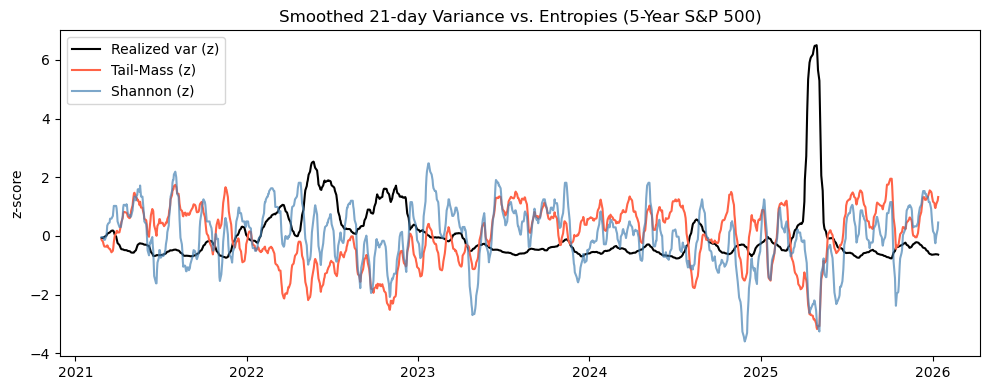

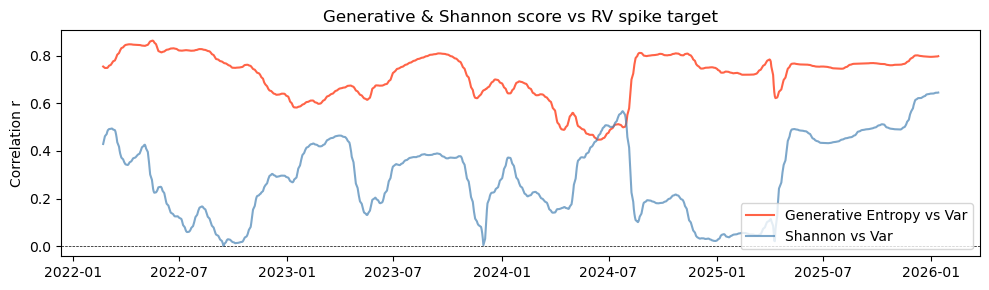

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

# 1. Fetch 5 years of S&P 500 (FRED series “SP500”)
end    = dt.datetime.today()
start  = end - dt.timedelta(days=5*365)
df     = pdr.DataReader('SP500', 'fred', start, end).dropna()
prices = df['SP500']   # pd.Series

# 2. Daily returns & 21-day realized variance
returns = prices.pct_change().dropna()
rv_21   = returns.rolling(21).var().dropna()

# 3. Compute entropies in rolling 21-day windows
bins   = 50
gamma  = 1.0
eps    = 1e-16
k      = returns.std()

H_vals, TM_vals, dates = [], [], []
rvals = returns.values
idxs  = returns.index

for i in range(21, len(rvals)+1):
    window = rvals[i-21:i]
    end_dt = idxs[i-1]
    counts, edges = np.histogram(window, bins=bins)
    p_all        = counts / counts.sum()
    centers      = edges[:-1] + np.diff(edges)/2
    
    nz = p_all > 0
    H  = -np.sum(p_all[nz] * np.log(p_all[nz] + eps))
    tail_mass = p_all[nz & (np.abs(centers)>k)].sum()
    S_tail    = H - gamma * tail_mass
    
    H_vals.append(H)
    TM_vals.append(S_tail)
    dates.append(end_dt)

H_series  = pd.Series(H_vals,  index=dates, name="Shannon")
TM_series = pd.Series(TM_vals, index=dates, name="TailMass")
rv_series = rv_21.loc[dates]

# 4. Smooth with a 7-day centered moving average
H_sm  = H_series.rolling(7, center=True).mean().dropna()
TM_sm = TM_series.rolling(7, center=True).mean().dropna()
rv_sm = rv_series.rolling(7, center=True).mean().dropna()

# 5. Z-score normalization
z = lambda s: (s - s.mean())/s.std()

# 6. Plot smoothed overlay
plt.figure(figsize=(10,4))
plt.plot(rv_sm.index, z(rv_sm),  label='Realized var (z)', color='k')
plt.plot(TM_sm.index, z(TM_sm),  label='Tail-Mass (z)',  color='tomato')
plt.plot(H_sm.index,  z(H_sm),   label='Shannon (z)',    color='steelblue', alpha=0.7)
plt.title("Smoothed 21-day Variance vs. Entropies (5-Year S&P 500)")
plt.ylabel("z-score")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Rolling Pearson correlation (250-day window)
window_size = 250
corr_TM = TM_sm.rolling(window_size).corr(rv_sm)
corr_SH = H_sm.rolling(window_size).corr(rv_sm)

# 8. Plot rolling correlations
plt.figure(figsize=(10,3))
plt.plot(corr_TM.index, np.abs(corr_TM), label='Generative Entropy vs Var', color='tomato')
plt.plot(corr_SH.index, np.abs(corr_SH), label='Shannon vs Var', color='steelblue', alpha=0.7)
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.title(f"Generative & Shannon score vs RV spike target")
plt.ylabel("Correlation r")
plt.legend()
plt.tight_layout()
plt.show()